# IBM SETI Tutorial

## Get data from Object Store and calculate features

In [1]:
#!pip install --user --upgrade ibmseti
#!pip install --user --upgrade ibmos2spark
import ibmseti
import ibmos2spark as oss
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
credentials_1 = {
  'auth_uri':'',
  'global_account_auth_uri':'',
  'username':'xxx',
  'password':"xxx",
  'auth_url':'https://identity.open.softlayer.com',
  'project':'xxx',
  'project_id':'xxx',
  'region':'dallas',
  'user_id':'xx',
  'domain_id':'xx',
  'domain_name':'xx',
  'container':'seti_raw_data',
  'tenantId':'xx'
}

credentials_1['name'] = 'my_seti_data'

In [3]:
bmos = oss.bluemix2d(sc, credentials_1)
rdd = sc.pickleFile(bmos.url('seti_raw_data', 'kepler1229b.sigdb.archive-compamps.rdd.dict.pickle'))

## Extract the Spectrograms from each file

In [4]:
def extract_spectrogram_and_bins(row):

    aca = ibmseti.compamp.Compamp(row['raw_data'])
    
    spect = ibmseti.dsp.compamp_to_spectrogram(aca)  
    
    #calculates the frequency (fb) and time (tb) bins
    fb = ibmseti.dsp.frequency_bins(aca.header())
    tb = ibmseti.dsp.time_bins(aca.header())

    return (tb, fb, aca.header(), spect)

In [5]:
rdd = rdd.map(extract_spectrogram_and_bins)

## Example Feature: "standard deviation" 

The calculation of the standard deviation of a set of values is used to measure the "width" of the distribution of those values about its central value. Typically this is done for sets of values which are the results of the measurement of a particlar property. However, in this case, it's used as a proxy to estimate if a signal exists in the spectrogram. If the signal is consistent over time, then the "standard deviation" along the time-axis will be large. But if the signal has significant power only within a small burst of time, the "standard deviation" along the time-axis will be small. Similarly for measures along the frequency-axis: small values are expected for narrow-band signals at a consistent frequency (low drift), while large values are expected for signals that either span a large range of frequencies. It should also be noted that the "standard deviation" along both time- and frequency-axis will be large if there is no signal. 

In [6]:
import math

def extract_mean_std(data):
    std_time = np.mean(np.sqrt(ibmseti.features.moment( data, axis=0, moment=2)))
    std_freq = np.mean(np.sqrt(ibmseti.features.moment( data, axis=1, moment=2)))
    return (std_time, std_freq)

In [7]:
rdd_features = rdd.map(lambda x: extract_mean_std(x[3]))

In [8]:
%time npfeat = np.array(rdd_features.collect())

CPU times: user 35.6 ms, sys: 12.7 ms, total: 48.3 ms
Wall time: 37.7 s


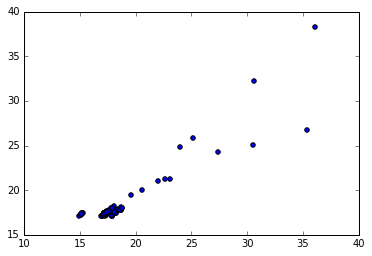

In [9]:
plt.scatter(npfeat[:, 0], npfeat[:, 1])
plt.show()

### Features In Context

Some work has been done already to extract the 'mean_std' features for all archive-compamp files.

http://imgur.com/siffvT8

From that link, you'll see these data fall right in the middle of that full archive-compamp set. The idea is to come up with features that allow for classification of signals. This is very much unexplored data!


## More features to be considered:

* std of spectrogram projected on time and freq axis
* third and fourth moments (std is sqrt(2nd moment))
* Log(pixel) histogram fits
* Entropy
* Total Variation
* Maximum Variation
* Mean first-difference
* 2nd, 3rd and 4th moments of first-difference
* Excess Kurtosis